In [1]:
%matplotlib inline

In [46]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp
import scipy.io
import scipy.signal as signal
import scipy.fftpack as ftpk
import matplotlib.pyplot as plt
import matplotlib

In [200]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2

In [3]:
import pywt
import pyhht

In [4]:
from imp import reload
import auxfilter
import glob

In [222]:
# os.chdir('..')
os.chdir('/home/mike/venvs/ml/ml/py')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, hurst

/home/mike/venvs/ml/ml/py


In [16]:
reload(plotstuff)

<module 'eegkaggle.plotting.plotstuff' from 'eegkaggle/plotting/plotstuff.py'>

In [6]:
matplotlib.style.use('ggplot')

In [7]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = slong

Functions

In [62]:
# this needs to be here because...reasons?
def pltcwt(plt, my_cwt, widths, realize=None):
    hi = np.max(widths)
    lo = np.min(widths)
    if realize == 'abs':
        my_cwt = np.abs(my_cwt)
    elif realize == 'ang':
        my_cwt = np.angle(my_cwt)
    plt.imshow(my_cwt, extent=[-1, 1, hi, lo], cmap='seismic', aspect='auto',
               vmax=abs(my_cwt).max(), vmin=-abs(my_cwt).max())


def plt_easycwt(plt, sig, widths):
    my_cwt = signal.cwt(sig, signal.ricker, widths)
    pltcwt(plt, my_cwt, widths)

Data loading section

In [10]:
basepath = '/home/mike/Downloads/train_1/'
path = basepath + '1_1_1.mat'
rawdata = dataio.get_matlab_eeg_data(path)
data = rawdata['data']
print(data.shape)
SR = rawdata['iEEGsamplingRate'][0][0]
if SR == int(SR):
    SR = int(SR)
print(SR)

(240000, 16)
400


In [ ]:
brief = data[:SR*120]
brief.shape

In [ ]:
plt.plot(brief[:,:2])

In [ ]:
eeg1 = brief[:,0]
eeg2 = brief[:,1]

In [ ]:
lo, hi = 1, 16
nbins = 32
widths = np.linspace(lo, hi, nbins)**2

In [ ]:
data.shape

In [ ]:
sig = data[:, 0]
fsig = ftpk.fft(data, axis=0)
t = np.linspace(0, 400, len(fsig))

fsig.shape


In [ ]:
plt.plot(np.linspace(0, 400, len(fsig)), fsig)

In [ ]:
sources1 = glob.glob(basepath + '*_1.mat') 
sources0 = glob.glob(basepath + '*_0.mat') 


In [ ]:
limit = 20
dataset0 = [ tools.matlabtools.get_matlab_eeg_data(path)['data'] for path in sources0[:limit]]
dataset1 = [ tools.matlabtools.get_matlab_eeg_data(path)['data'] for path in sources1[:limit]]


In [ ]:
dataset0[0].shape

In [ ]:
spectra = [ftpk.fft(datas, axis=0) for datas in dataset0]
spectra = np.array(spectra)
spectra1 = np.array([ftpk.fft(datas, axis=0) for datas in dataset1])
spectra.shape

In [ ]:
flat = np.average(spectra, axis=0)
flatstd = np.std(spectra, axis=0)
flat1 = np.average(spectra1, axis=0)
flatstd1 = np.std(spectra1, axis=0)
flat.shape

In [ ]:
cut = 100*240000/400
plt.plot(t[:cut], flat[:cut,0])

In [ ]:
plt.plot(t[:cut], flat[:cut,0])
plt.plot(t[:cut], flat1[:cut,0])

In [ ]:
plt.plot(t[:cut], flatstd[:cut,0])
plt.plot(t[:cut], flatstd1[:cut,0])
len(t[:cut])

In [ ]:
len(t)/400

In [11]:
d0 = dataio.get_matlab_eeg_data(basepath + '1_102_0.mat')
d1 = dataio.get_matlab_eeg_data(basepath + '1_102_1.mat')

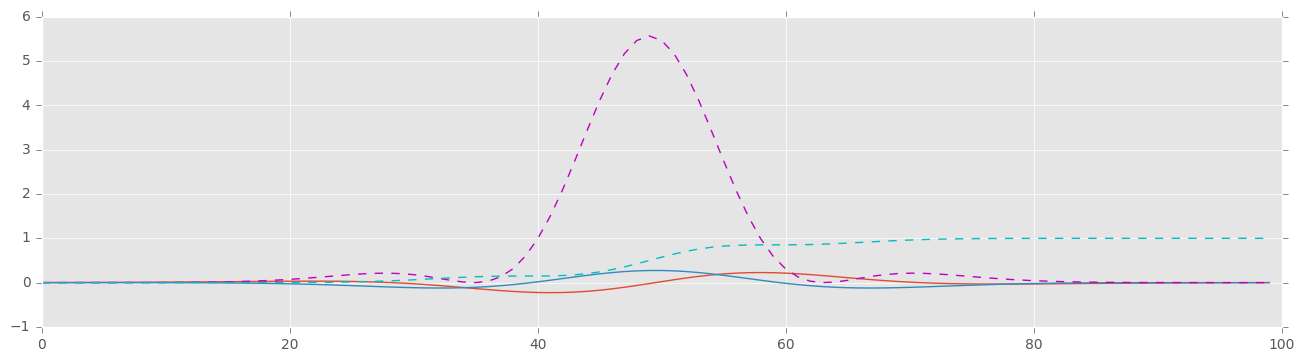

In [87]:
reload(plotstuff)
base = (100,10)
y = plotstuff.ricker_i(*base)

plt.plot(y)
plt.plot(signal.ricker(*base))
plt.plot(np.cumsum(y)**2, 'm--')
plt.plot(np.cumsum(signal.ricker(*base)**2), 'c--')

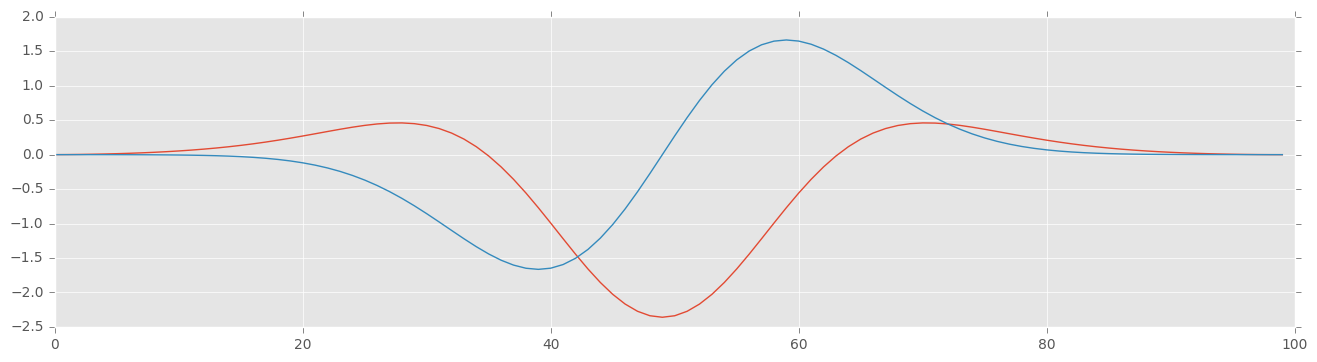

In [88]:
plt.plot(np.cumsum(y))
plt.plot(np.cumsum(signal.ricker(*base)))

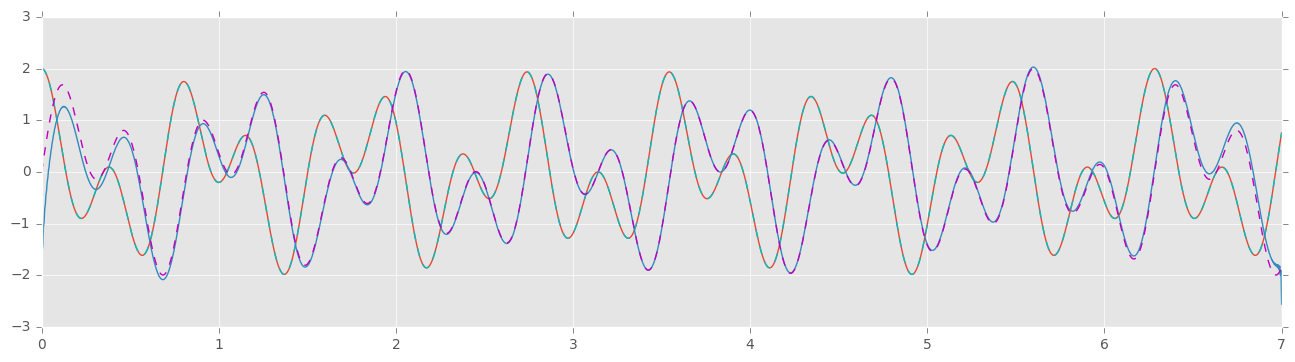

In [145]:
# Let's check all of our assumptions at the door and make sure all the frequency operations work right
t = np.linspace(0, 7, 2000)
f1, f2 = 16, 7
# sig = np.cos(f1*t) + np.cos(f2*t)
sig_e = np.exp(1j *f1 * t ) + np.exp(1j * f2 * t)
sig = np.real(sig_e)
plt.plot(t, sig)
plt.plot(t, np.real(sig_e), 'c--')
plt.plot(t, np.imag(signal.hilbert(sig)))
plt.plot(t, np.imag(sig_e), 'm--')

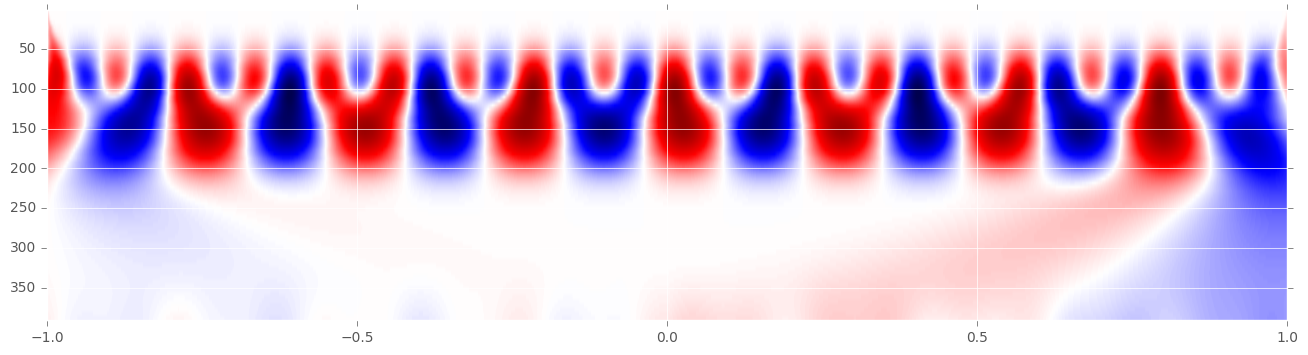

In [146]:
widths = np.arange(1,20,.25)**2
cw = signal.cwt(sig, signal.ricker, widths)
cwi = signal.cwt(sig, plotstuff.ricker_i, widths)

plotstuff.pltcwt(plt, cw, widths)
# plt_easycwt(plt, sig, widths)
# plt.imshow(cw)

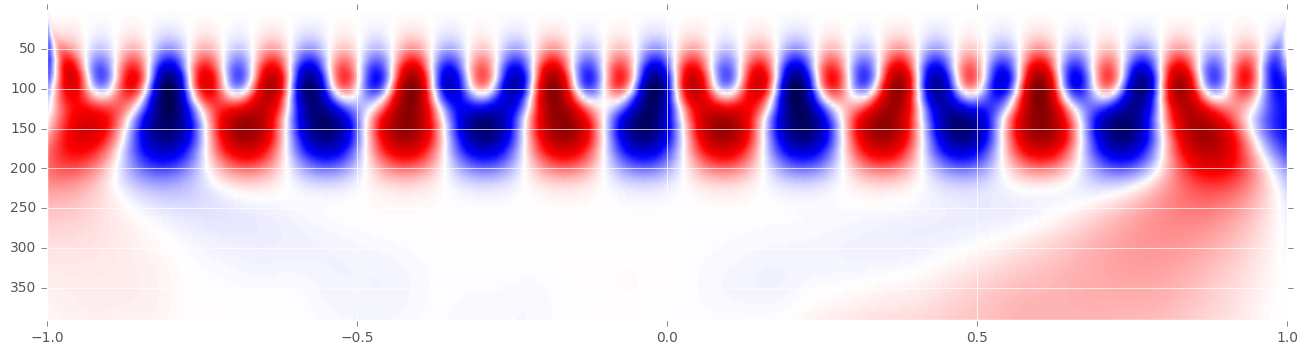

In [147]:
plotstuff.pltcwt(plt, cwi, widths)

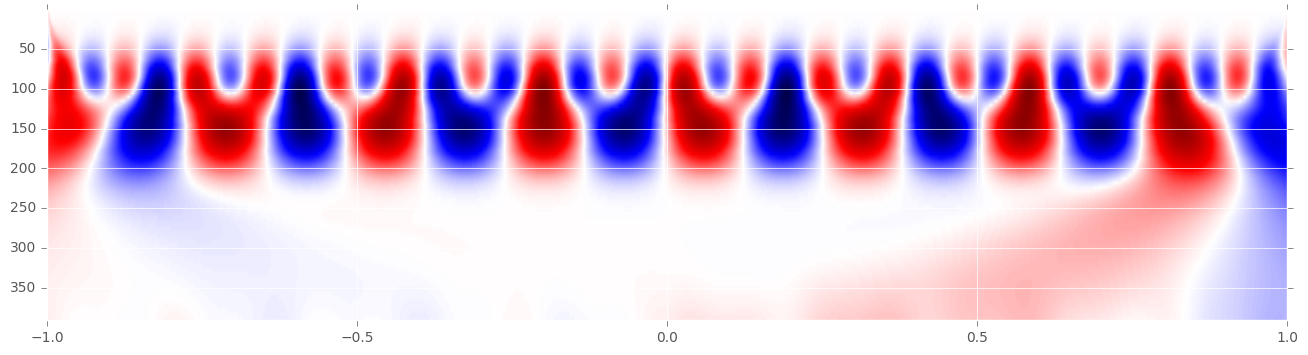

In [148]:
plotstuff.pltcwt(plt, cw + cwi, widths)


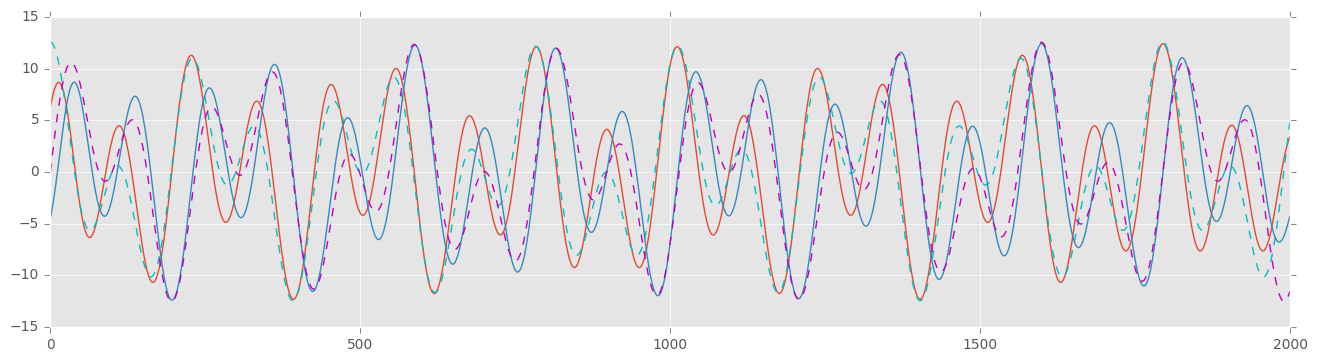

In [149]:
n = 17
plt.plot(cw[n])
plt.plot(sig*2*pi, 'c--')
plt.plot(cwi[n])
plt.plot(np.imag(sig_e)*2*pi, 'm--')

### That's actually pretty good for SWAG'ing it. 

<type 'numpy.ndarray'>
(76, 2000) (76, 2000) (2000,)


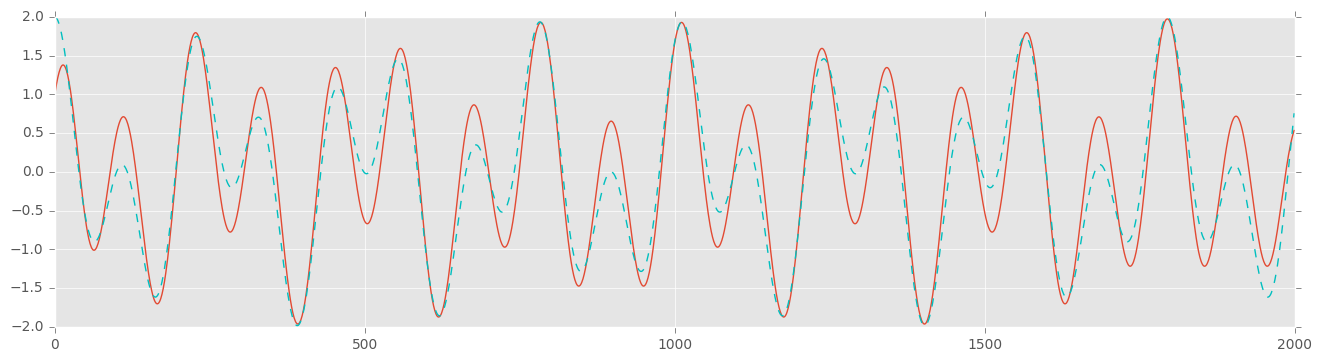

In [150]:
cw_a = np.add(cw[n], 1j*cwi[n]) / twopi
print(type(cw_a))
print(cw.shape, cwi.shape, cw_a.shape)
plt.plot(np.real(cw_a))
plt.plot(np.real(sig_e), 'c--')

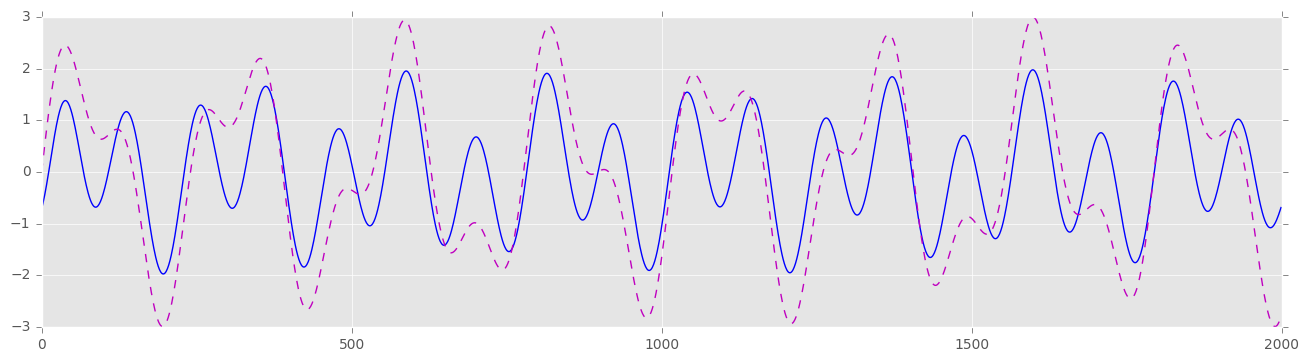

In [142]:
plt.plot(np.imag(cw_a), 'b')
plt.plot(np.imag(sig_e), 'm--')

### Ehhhhh..... it's close-ish enough, I think. Especially since the buckets are not exact. 
Okay, so roughly speaking:
$$ cw_{\phi,sig} ≈ \frac{1}{2\pi}[W_{\phi,t}(sig) + W'_{\phi,t}(sig)] $$

where $W_{\phi,t}$ is a real wavelet kernel centered at frequency $\phi$, and W' is the Hilbert transform of W, $W' = H(W)(t)$

In [169]:
reload(wavelets)
widths = np.arange(1,20,1)**2
sig_e = np.exp(1j *f1 * t ) + 2*np.exp(1j * f2 * t**1.22)
sig = np.real(sig_e)
magic_k = 17# pi*5.4
print(magic_k)
a_sig = wavelets.acwt(sig, widths) * magic_k

17


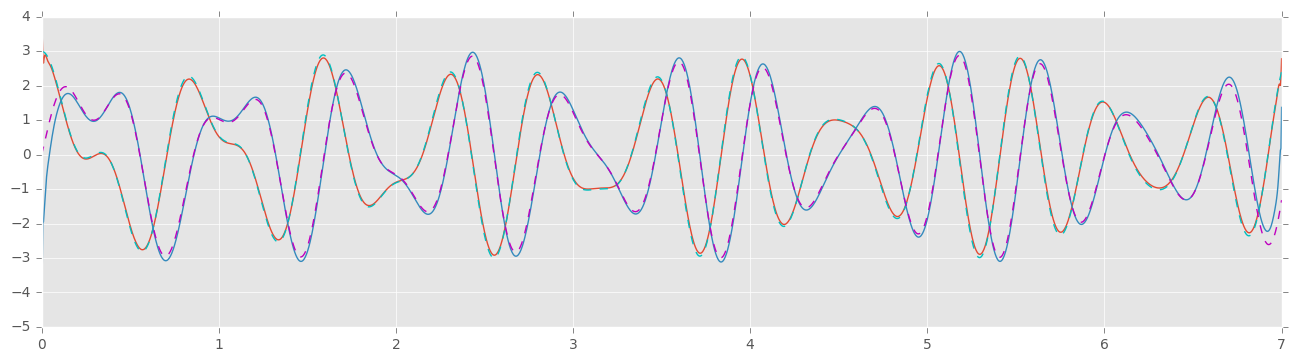

In [170]:
plt.plot(t, a_sig)
plt.plot(t, np.real(sig_e), 'c--')
plt.plot(t, np.imag(a_sig))
plt.plot(t, np.imag(sig_e), 'm--')

array([[ 1.00000000+0.j        ,  0.99387676+0.02787955j],
       [ 0.99387676-0.02787955j,  1.00000000+0.j        ]])

In [213]:
a_sig = wavelets.acwt(sig, widths) 
corr = []
X = np.arange(16.8548,16.8549,.000000001)
for i in X:
    ccor = np.sum(np.abs((sig_e - a_sig*i)**2))
    corr.append(ccor)
    

min_idx = np.argmin(corr)
minx = X[min_idx]
miny = corr[min_idx]
print(minx, miny)

16.854880972 118.380203148


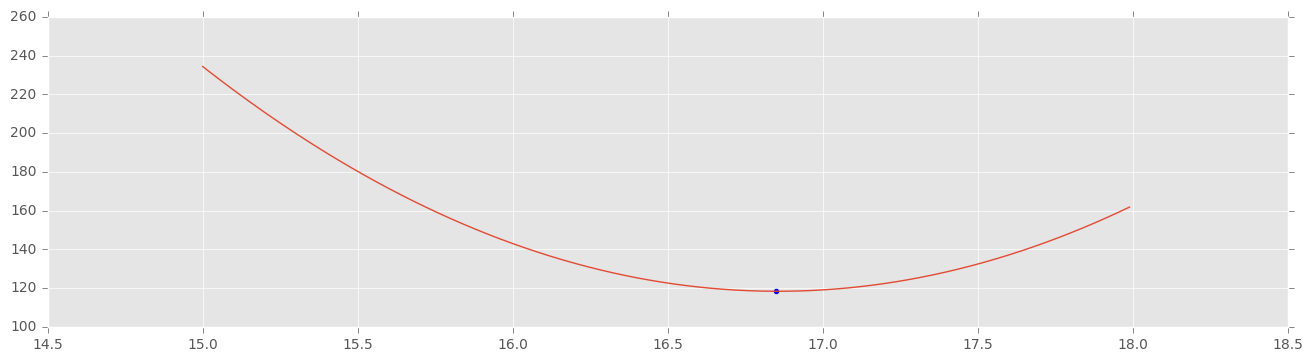

In [190]:
plt.plot(X, corr)
plt.scatter(minx, miny)

In [207]:
e**e

15.154262241479259

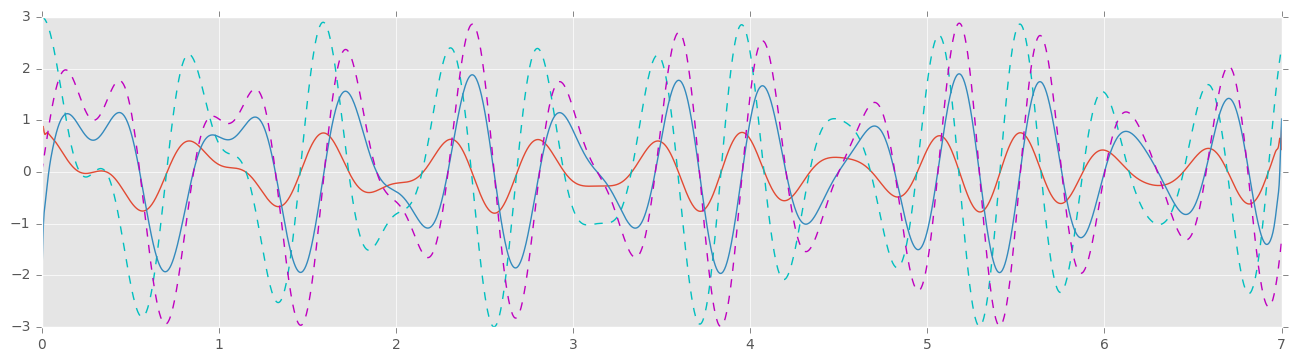

In [221]:
reload(wavelets)
widths = np.arange(.5,30,1)**2 # change this to make sure the constant is still stable
sig_e = np.exp(1j *f1 * t ) + 2*np.exp(1j * f2 * t**1.22)
sig = np.real(sig_e)
a_sig = wavelets.acwt(sig, widths)# * magic_k
plt.plot(t, a_sig)
plt.plot(t, np.real(sig_e), 'c--')
plt.plot(t, np.imag(a_sig))
plt.plot(t, np.imag(sig_e), 'm--')

Well, balls, I guess it's not a constant scaling factor after all. 

In [226]:
h = hurst.hurst(np.real(sig))
p = np.log10(np.cumsum(np.random.randn(50000))+1000) # random walk, hurst ~ 0.5

r = hurst.hurst(p)
print(h)
print(r)

0.986254178983
0.505954463047
